In [1]:
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, List
from operator import add
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display


## Sequential Plan generation

In [6]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    plan: List[str]
    dynatrace_result: str
    log_result: str

def planner(state: AgentState) -> AgentState:
    query = state["messages"][-1].content.lower()
    plan = []

    if "performance" in query or "slow" in query:
        plan.append("dynatrace")
    if "error" in query or "exception" in query:
        plan.append("log_exceptions")
    if not plan:
        plan = ["dynatrace", "log_exceptions"]

    state["plan"] = plan
    print(f"[planner] Generated plan: {plan}")
    return state

def dispatcher(state: AgentState) -> dict:
    print(f"[dispatcher] Current plan: {state['plan']}")
    if not state["plan"]:
        print("[dispatcher] Plan empty → routing to final_answer")
        return {"next_step": "final_answer"}
    print(f"[dispatcher] Routing to: {state['plan'][0]}")
    return {"next_step": state["plan"][0]}

def dynatrace_agent(state: AgentState) -> AgentState:
    print("[dynatrace_agent] Running Dynatrace diagnostics...")
    state["dynatrace_result"] = "CPU spike detected in backend pod"
    return state

def log_exceptions_agent(state: AgentState) -> AgentState:
    print("[log_exceptions_agent] Running log analysis...")
    state["log_result"] = "NullPointerException in user-service"
    return state

def update_plan(state: AgentState) -> AgentState:
    print(f"[update_plan] Plan before update: {state['plan']}")
    state["plan"] = state["plan"][1:]
    print(f"[update_plan] Plan after update: {state['plan']}")
    return state

def final_answer_agent(state: AgentState) -> AgentState:
    print("[final_answer_agent] Preparing final output...")
    summary = "Issue Summary:\n"
    if state.get("dynatrace_result"):
        summary += f"- Infra: {state['dynatrace_result']}\n"
    if state.get("log_result"):
        summary += f"- Logs: {state['log_result']}\n"
    print("[final_answer_agent] Final summary prepared.")
    state["messages"].append(HumanMessage(content=summary.strip()))
    return state

# --- Step: pop completed item from plan
def update_plan(state: AgentState) -> AgentState:
    state["plan"] = state["plan"][1:]
    return state

# --- Build Graph ---
builder = StateGraph(AgentState)
builder.add_node("dispatcher", dispatcher)
builder.add_node("planner", planner)
builder.add_node("dynatrace", dynatrace_agent)
builder.add_node("log_exceptions", log_exceptions_agent)
builder.add_node("update_plan", update_plan)
builder.add_node("final_answer", final_answer_agent)

builder.set_entry_point("planner")

# Conditional routing based on plan
# ✅ Conditional logic reads "next_step"
builder.add_conditional_edges(
    "dispatcher",
    lambda state: state["next_step"],
    {
        "dynatrace": "dynatrace",
        "log_exceptions": "log_exceptions",
        "final_answer": "final_answer"
    }
)

# Connect graph
builder.add_edge("planner", "dispatcher")
builder.add_edge("dynatrace", "update_plan")
builder.add_edge("log_exceptions", "update_plan")
builder.add_edge("update_plan", "dispatcher")

builder.set_finish_point("final_answer")

# Compile graph

graph = builder.compile()



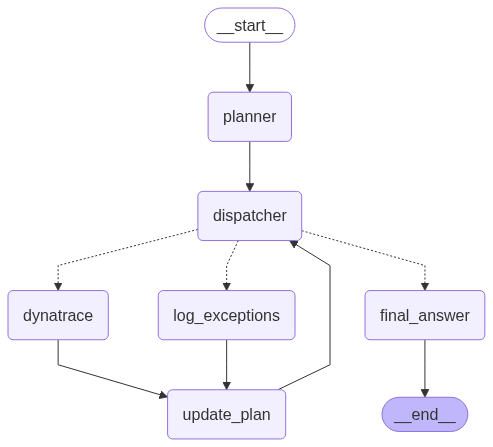

In [7]:
# --- Visualize
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))



In [8]:
# --- Run
initial_state = {
    "messages": [HumanMessage(content="What's wrong with my application?")],
    "dynatrace_result": "",
    "log_result": "",
    "plan": []
}

final_state = graph.invoke(initial_state)
print(final_state["messages"][-1].content)

[planner] Generated plan: ['dynatrace', 'log_exceptions']
[dispatcher] Current plan: ['dynatrace', 'log_exceptions']
[dispatcher] Routing to: dynatrace
[dynatrace_agent] Running Dynatrace diagnostics...
[dispatcher] Current plan: ['log_exceptions']
[dispatcher] Routing to: log_exceptions
[log_exceptions_agent] Running log analysis...
[dispatcher] Current plan: []
[dispatcher] Plan empty → routing to final_answer
[final_answer_agent] Preparing final output...
[final_answer_agent] Final summary prepared.
Issue Summary:
- Infra: CPU spike detected in backend pod
- Logs: NullPointerException in user-service


In [ ]:
## Parallen Plan Execution- Simple

In [9]:
# --- Imports ---
from langgraph.graph import StateGraph, END, START
from typing import Annotated, TypedDict, List
from operator import add
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.runnables import RunnableParallel
from IPython.display import display, Image

In [10]:
# --- State Definition ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    plan: List[str]
    dynatrace_result: str
    log_result: str

# --- Planner Node ---
def planner(state: AgentState) -> AgentState:
    query = state["messages"][-1].content.lower()
    plan = []

    if "performance" in query or "slow" in query:
        plan.append("dynatrace")
    if "error" in query or "exception" in query:
        plan.append("log_exceptions")
    if not plan:
        plan = ["dynatrace", "log_exceptions"]

    state["plan"] = plan
    print(f"[planner] Generated plan: {plan}")
    return state

# --- Tool: Dynatrace ---
def dynatrace_agent(state: AgentState) -> AgentState:
    print("[dynatrace_agent] Running Dynatrace diagnostics...")
    return {"dynatrace_result": "CPU spike detected in backend pod"}

# --- Tool: Logs ---
def log_exceptions_agent(state: AgentState) -> AgentState:
    print("[log_exceptions_agent] Running log analysis...")
    return {"log_result": "NullPointerException in user-service"}

# --- Parallel Executor Node ---
def parallel_executor(state: AgentState) -> AgentState:
    plan = state["plan"]
    tools = {}

    if "dynatrace" in plan:
        tools["dynatrace_result"] = dynatrace_agent
    if "log_exceptions" in plan:
        tools["log_result"] = log_exceptions_agent

    print(f"[parallel_executor] Executing tools in parallel: {list(tools.keys())}")
    runner = RunnableParallel(tools)
    tool_outputs = runner.invoke(state)

    print(f"[parallel_executor] Results: {tool_outputs}")
    state.update(tool_outputs)
    return state

# --- Final Answer Node ---
def final_answer_agent(state: AgentState) -> AgentState:
    print("[final_answer_agent] Preparing final output...")
    summary = "Issue Summary:\n"
    if state.get("dynatrace_result"):
        summary += f"- Infra: {state['dynatrace_result']}\n"
    if state.get("log_result"):
        summary += f"- Logs: {state['log_result']}\n"
    state["messages"].append(HumanMessage(content=summary.strip()))
    print("[final_answer_agent] Final summary prepared.")
    return state

# --- Build Graph ---
builder = StateGraph(AgentState)
builder.add_node("planner", planner)
builder.add_node("parallel_executor", parallel_executor)
builder.add_node("final_answer", final_answer_agent)

builder.set_entry_point("planner")
builder.add_edge("planner", "parallel_executor")
builder.add_edge("parallel_executor", "final_answer")
builder.set_finish_point("final_answer")

graph = builder.compile()


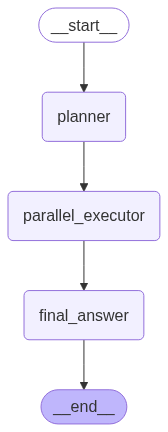

In [11]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [12]:
# --- Run the Graph ---
initial_state = {
    "messages": [HumanMessage(content="What's wrong with my application?")],
    "plan": [],
    "dynatrace_result": "",
    "log_result": ""
}

final_state = graph.invoke(initial_state)
print(final_state["messages"][-1].content)

[planner] Generated plan: ['dynatrace', 'log_exceptions']
[parallel_executor] Executing tools in parallel: ['dynatrace_result', 'log_result']
[dynatrace_agent] Running Dynatrace diagnostics...
[log_exceptions_agent] Running log analysis...
[parallel_executor] Results: {'dynatrace_result': {'dynatrace_result': 'CPU spike detected in backend pod'}, 'log_result': {'log_result': 'NullPointerException in user-service'}}
[final_answer_agent] Preparing final output...
[final_answer_agent] Final summary prepared.
Issue Summary:
- Infra: {'dynatrace_result': 'CPU spike detected in backend pod'}
- Logs: {'log_result': 'NullPointerException in user-service'}


In [ ]:
## parallel Eecition with Aysnc io

In [13]:
# --- Imports ---
import asyncio
from typing import Annotated, TypedDict, List
from operator import add

from langchain_core.runnables import RunnableParallel, RunnableLambda
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph import StateGraph
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image


In [14]:
# --- Step 1: Define State ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    plan: List[str]
    dynatrace_result: str
    log_result: str

# --- Step 2: Async Planner Node ---
async def planner(state: AgentState) -> AgentState:
    query = state["messages"][-1].content.lower()
    plan = []

    if "performance" in query or "slow" in query:
        plan.append("dynatrace")
    if "error" in query or "exception" in query:
        plan.append("log_exceptions")
    if not plan:
        plan = ["dynatrace", "log_exceptions"]

    state["plan"] = plan
    print(f"[planner] Generated plan: {plan}")
    return state

# --- Step 3: Async Diagnostic Tools ---

async def dynatrace_agent_async(state):
    print("[dynatrace_agent_async] Simulating async work...")
    await asyncio.sleep(1)
    return "CPU spike detected in backend pod"

async def log_exceptions_agent_async(state):
    print("[log_exceptions_agent_async] Simulating async work...")
    await asyncio.sleep(1)
    return "NullPointerException in user-service"

# --- Step 4: Parallel Executor Node ---
async def parallel_executor(state: AgentState) -> AgentState:
    plan = state["plan"]
    tools = {}

    if "dynatrace" in plan:
        tools["dynatrace_result"] = RunnableLambda(dynatrace_agent_async)
    if "log_exceptions" in plan:
        tools["log_result"] = RunnableLambda(log_exceptions_agent_async)

    print(f"[parallel_executor] Running in parallel: {list(tools.keys())}")
    parallel_runner = RunnableParallel(tools)
    results = await parallel_runner.ainvoke(state)

    print(f"[parallel_executor] Results: {results}")
    state.update(results)
    return state

# --- Step 5: Final Summarizer Node ---
async def final_answer_agent(state: AgentState) -> AgentState:
    print("[final_answer_agent] Creating summary...")
    summary = "Issue Summary:\n"
    if state.get("dynatrace_result"):
        summary += f"- Infra: {state['dynatrace_result']}\n"
    if state.get("log_result"):
        summary += f"- Logs: {state['log_result']}\n"
    state["messages"].append(HumanMessage(content=summary.strip()))
    return state

# --- Step 6: Build LangGraph ---
builder = StateGraph(AgentState)

builder.add_node("planner", planner)
builder.add_node("parallel_executor", parallel_executor)
builder.add_node("final_answer", final_answer_agent)

builder.set_entry_point("planner")
builder.add_edge("planner", "parallel_executor")
builder.add_edge("parallel_executor", "final_answer")
builder.set_finish_point("final_answer")

graph = builder.compile()


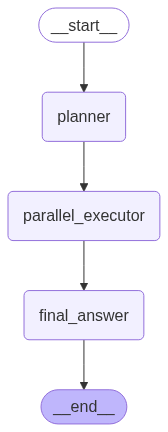

In [15]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [16]:
# --- Step 7: Run the Graph ---
initial_state = {
    "messages": [HumanMessage(content="What's wrong with my application?")],
    "plan": [],
    "dynatrace_result": "",
    "log_result": ""
}

final_state = await graph.ainvoke(initial_state)
print("\n✅ Final Response:\n", final_state["messages"][-1].content)

[planner] Generated plan: ['dynatrace', 'log_exceptions']
[parallel_executor] Running in parallel: ['dynatrace_result', 'log_result']
[dynatrace_agent_async] Simulating async work...
[log_exceptions_agent_async] Simulating async work...
[parallel_executor] Results: {'dynatrace_result': 'CPU spike detected in backend pod', 'log_result': 'NullPointerException in user-service'}
[final_answer_agent] Creating summary...

✅ Final Response:
 Issue Summary:
- Infra: CPU spike detected in backend pod
- Logs: NullPointerException in user-service
